In [1]:
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
def list_all_runs_for_baseline(level, each_run_dirs, display_match=False):
    dir_regex =f"^BabyAI-{level}-v0_ppo_bow_endpool_res_gru_mem_seed"
    runs = []
    for dir_name in each_run_dirs:
        if re.match(dir_regex, dir_name):
            runs.append(dir_name)
            if display_match:
                print(dir_name)
    print(f"Found {len(runs)} baseline runs for {level}")
    return runs

def list_all_runs_per_lang_train_mode(level, each_run_dirs, lang_train_mode, display_match=False):
    dir_regex =f"^BabyAI-{level}-v0_ppo_HRL-Flamingo_full_all_Lang{lang_train_mode}"
    runs = []
    for dir_name in each_run_dirs:
        if re.match(dir_regex, dir_name):
            runs.append(dir_name)
            if display_match:
                print(dir_name)
    print(f"Found {len(runs)} runs for {level} with lang_train_mode={lang_train_mode}")
    return runs

def load_log(dir_, level):
    """Loads log from a directory and adds it to a list of dataframes."""
    df = pd.read_csv(os.path.join(dir_, 'log.csv'))
    if not len(df):
        print("empty df at {}".format(dir_))
        return
    df['level'] = level
    df['model'] = dir_
    seed_regrex = f"seed\d+"
    df['seed'] = int(re.findall(seed_regrex, dir_, flags=re.IGNORECASE)[0][4:])
    return df

def load_runs_of_all_seeds_for_one_config(level, env_data_dir, list_of_dirs):
    data = []
    for dir_name in list_of_dirs:
        data.append(load_log(os.path.join(env_data_dir, dir_name), level))
    return data

def get_plot_data(list_of_pd_data, sel_cols, sel_cond):
    plot_data = []
    for pd_data in list_of_pd_data:
        plot_data.append(pd_data[sel_cols][sel_cond])
    return plot_data


def create_segments(points, left_extension_x=0.0, right_extention_x=1e6):
    """
    Creates a list of line segments from the input list of 2D points.

    Args:
    points (list): List of 2D points (x, y) as tuples.
    extension (float): The extension value for the first and last line segments.

    Returns:
    list: List of line segments as tuples (point1, point2).
    """
    segments = []
    for i in range(len(points) - 1):
        point1, point2 = points[i], points[i + 1]
        if (i == 0) and (left_extension_x < point1[0]):
            dx = point2[0] - point1[0]
            dy = point2[1] - point1[1]
            left_extension_y = point1[1] - (point1[0]-left_extension_x) * (dy/dx)
            point1 = (left_extension_x, left_extension_y)
        if (i == len(points) - 2) and (right_extention_x > point2[0]):
            dx = point2[0] - point1[0]
            dy = point2[1] - point1[1]
            right_extention_y = point2[1] + (right_extention_x-point2[0]) * (dy/dx)
            point2 = (right_extention_x, right_extention_y)
        segments.append((point1, point2))
    return segments

def sample_from_line(segments, x_values):
    """
    Samples points from the created line segments.

    Args:
    segments (list): List of line segments as tuples (point1, point2).
    x_values (list): List of x values for which the corresponding y values are needed.

    Returns:
    list: List of sampled points (x, y) as tuples.
    """
    sampled_points = []

    for x in x_values:
        for segment in segments:
            point1, point2 = segment
            if point1[0] <= x <= point2[0]:
                t = (x - point1[0]) / (point2[0] - point1[0])
                sampled_y = point1[1] + t * (point2[1] - point1[1])
                sampled_points.append((x, sampled_y))
                break

    return sampled_points

import matplotlib.pyplot as plt

def plot_segments(segments, points=None, sampled_points=None):
    """
    Plots the created line segments.

    Args:
    segments (list): List of line segments as tuples (point1, point2).
    points (list, optional): List of original 2D points (x, y) as tuples.
    sampled_points (list, optional): List of sampled 2D points (x, y) as tuples.
    """

    # Plot line segments
    for segment in segments:
        point1, point2 = segment
        plt.plot([point1[0], point2[0]], [point1[1], point2[1]], 'b-')

    # Plot original points
    if points:
        x, y = zip(*points)
        plt.plot(x, y, 'ro', label='Original Points')

    # Plot sampled points
    if sampled_points:
        x, y = zip(*sampled_points)
        plt.plot(x, y, 'g+', label='Sampled Points')

    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

    if points or sampled_points:
        plt.legend()

    plt.show()

def find_largest_number_of_points(list_of_lines_of_points):
    """
    Finds the largest number of points in the input list of lines of points.

    Args:
    list_of_lines_of_points (list): List of lines of points.

    Returns:
    int: The largest number of points in the input list of lines of points.
    """
    largest_number_of_points = 0
    for line_of_points in list_of_lines_of_points:
        if len(line_of_points) > largest_number_of_points:
            largest_number_of_points = len(line_of_points)
    return largest_number_of_points

def plot_perf_per_lang_mode_per_level(
        level,
        lang_comp_mode,
        short_lr_list,
        line_colors,
        line_styles,
        df_3lr_3lang,
        df_paper_levels,
        fig_dir,
        gh = None,
        debug=False,
        num_samples = None
):
    segments_3lr_3seeds = {}
    max_num_points_3lr = {}
    for key, lr in short_lr_list.items():
        segments_3lr_3seeds[lr] = []
        max_num_points_3lr[lr] = 0
    num_seeds=3
    min_x=0.0
    max_x=1e6
    gh = None
    df_3lr_1lang = df_3lr_3lang[lang_comp_mode]
    line_style = line_styles[lang_comp_mode]
    num_samples_is_provided = num_samples is not None

    # Load data
    for key, lr in short_lr_list.items():
        for i in range(3):
            frames_rewards_i = list(zip(df_3lr_1lang[lr][i]['frames'],df_3lr_1lang[lr][i]['return_mean']))
            points = sorted(frames_rewards_i, key=lambda x: x[0])
            if debug:
                print(f"[LR({lr}, Run {i})] left: {points[0]}, right: {points[-1]}, num_points: {len(points)}")

            segments_i = create_segments(points, left_extension_x=min_x, right_extention_x=max_x)
            segments_3lr_3seeds[lr].append(segments_i)
            if debug:
                print(f"[LR({lr}, Extend)] left: {segments_i[0][0]}, right: {segments_i[-1][1]}, num_points: {len(segments_i)+1}")

        max_num_points = find_largest_number_of_points(segments_3lr_3seeds[lr])+1
        max_num_points_3lr[lr] = max_num_points
        if debug:
            print(f"[LR({lr})] max_num_points: {max_num_points}\n")

    # Draw samples from segment lines and plot
    plt.figure()
    for key, lr in short_lr_list.items():
        line_color = line_colors[lr]
        if not num_samples_is_provided:
            num_samples = max_num_points_3lr[lr]
        segments_3seeds = segments_3lr_3seeds[lr]

        x_values = np.random.uniform(min_x, max_x, num_samples)
        x_values.sort()

        df_3seeds = []
        for segments, i in zip(segments_3seeds, range(num_seeds)):
            sampled_points = sample_from_line(segments, x_values)
            df = pd.DataFrame(sampled_points, columns=['frames', 'return_mean'])
            df_3seeds.append(df)
        df_3seeds = pd.concat(df_3seeds, axis=0)

        if gh is None:
            gh = sns.lineplot(x='frames', y='return_mean', data=df_3seeds, errorbar='se', err_style='band', label=f"{lang_comp_mode}_lr{lr}_3Seeds", color=line_color, linestyle=line_style)
        else:
            sns.lineplot(x='frames', y='return_mean', data=df_3seeds, errorbar='se', err_style='band', label=f"{lang_comp_mode}_lr{lr}_3Seeds", color=line_color, linestyle=line_style, ax=gh)

    baseline_data = df_paper_levels[df_paper_levels['level']==level]
    baseline_data = baseline_data[baseline_data['frames']<=max_x]
    sns.lineplot(x='frames', y='return_mean', data=baseline_data, errorbar='se', err_style='band', color="blue",  label='Baseline_3Seeds', ax=gh)

    gh.set(xlabel='Frames', ylabel='Average Return')
    fn = f"Img_{level}_{lang_comp_mode}_3lr_perf.pdf"
    fig_fp = os.path.join(fig_dir, fn)
    gh.figure.savefig(fig_fp, dpi=600, format='pdf')
    plt.show()
    plt.close(gh.figure)

def plot_best_perf_every_lang_mode_per_level(
        level,
        lang_comp_mode_and_lr_pairs,
        line_colors,
        line_styles,
        df_3lr_3lang,
        df_paper_levels,
        fig_dir,
        gh = None,
        debug=False,
        num_samples=None,
):
    segments_3configs_3seeds = {}
    max_num_points_3configs = {}

    num_seeds=3
    min_x=0.0
    max_x=1e6
    gh = None
    num_samples_is_provided = num_samples is not None

    # Load data
    for lang_comp_mode, lr in lang_comp_mode_and_lr_pairs.items():
        df_3seeds = df_3lr_3lang[lang_comp_mode][lr]

        new_key = f"{lang_comp_mode}_lr{lr}"
        segments_3configs_3seeds[new_key] = []
        max_num_points_3configs[new_key] = 0

        for i in range(3):
            frames_rewards_i = list(zip(df_3seeds[i]['frames'], df_3seeds[i]['return_mean']))
            points = sorted(frames_rewards_i, key=lambda x: x[0])
            if debug:
                print(f"[LR({lr}, Run {i})] left: {points[0]}, right: {points[-1]}, num_points: {len(points)}")

            segments_i = create_segments(points, left_extension_x=min_x, right_extention_x=max_x)
            segments_3configs_3seeds[new_key].append(segments_i)
            if debug:
                print(f"[LR({lr}, Extend)] left: {segments_i[0][0]}, right: {segments_i[-1][1]}, num_points: {len(segments_i)+1}")

        max_num_points = find_largest_number_of_points(segments_3configs_3seeds[new_key])+1
        max_num_points_3configs[new_key]= max_num_points
        if debug:
            print(f"[LR({lr})] max_num_points: {max_num_points}\n")

    # Draw samples from segment lines and plot
    plt.figure()
    for lang_comp_mode, lr in lang_comp_mode_and_lr_pairs.items():
        new_key = f"{lang_comp_mode}_lr{lr}"

        line_color = line_colors[lr]
        line_style = line_styles[lang_comp_mode]
        if not num_samples_is_provided:
            num_samples = max_num_points_3configs[new_key]
        segments_3seeds = segments_3configs_3seeds[new_key]

        x_values = np.random.uniform(min_x, max_x, num_samples)
        x_values.sort()

        df_3seeds = []
        for segments, i in zip(segments_3seeds, range(num_seeds)):
            sampled_points = sample_from_line(segments, x_values)
            df = pd.DataFrame(sampled_points, columns=['frames', 'return_mean'])
            df_3seeds.append(df)
        df_3seeds = pd.concat(df_3seeds, axis=0)

        if gh is None:
            gh = sns.lineplot(x='frames', y='return_mean', data=df_3seeds, errorbar='se', err_style='band', label=f"{lang_comp_mode}_lr{lr}_3Seeds", color=line_color, linestyle=line_style)
        else:
            sns.lineplot(x='frames', y='return_mean', data=df_3seeds, errorbar='se', err_style='band', label=f"{lang_comp_mode}_lr{lr}_3Seeds", color=line_color, linestyle=line_style, ax=gh)

    baseline_data = df_paper_levels[df_paper_levels['level']==level]
    baseline_data = baseline_data[baseline_data['frames']<=max_x]
    sns.lineplot(x='frames', y='return_mean', data=baseline_data, errorbar='se', err_style='band', color="blue",  label='Baseline_3Seeds', ax=gh)

    gh.set(xlabel='Frames', ylabel='Average Return')
    fn = f"Img_best_perf_per_lang_mode_for_{level}.pdf"
    fig_fp = os.path.join(fig_dir, fn)
    gh.figure.savefig(fig_fp, dpi=600, format='pdf')
    plt.show()
    plt.close(gh.figure)


def load_result_per_level(
        exp_result_dir,
        level,
        lr_list,
        short_lr_list,
        lang_comp_modes,
        history_type='full',
        ):

    level_exp_result_dir= os.path.join(exp_result_dir, level)
    each_run_dirs = os.listdir(level_exp_result_dir)
    print(f"total runs: {len(each_run_dirs)}")

    df_3lr_3lang = {}
    loaded_runs = 0
    for lang_comp_mode in lang_comp_modes:
        df_3lr_3lang[lang_comp_mode] = {}
        for lr in lr_list:
            short_lr_name = short_lr_list[lr]
            df_3lr_3lang[lang_comp_mode][short_lr_name] = []

    for run_dir in each_run_dirs:
        for lang_comp_mode in lang_comp_modes:
            for lr in lr_list:
                filename_regex = f"^BabyAI-{level}-v0_ppo_HRL-Flamingo_full_all_Lang{lang_comp_mode}_noPrior_lr{lr}"
                if re.match(filename_regex, run_dir):
                    df = load_log(os.path.join(level_exp_result_dir, run_dir), level)
                    short_lr_name = short_lr_list[lr]
                    df['lr'] = short_lr_name
                    df['lang_mode'] = lang_comp_mode
                    df_3lr_3lang[lang_comp_mode][short_lr_name].append(df)
                    loaded_runs += 1
    print(f"loaded runs: {loaded_runs}")
    return df_3lr_3lang

def plot_line_segments_example(
        level,
        lang_comp_mode,
        lr,
        df_3lr_3lang,
        df_paper_levels,
        fig_dir,
        debug=False,
        num_samples=None
):
    num_samples_is_provided = num_samples is not None

    df_3seeds = df_3lr_3lang[lang_comp_mode][lr]
    seeds = [df_3seeds[i]['seed'].unique()[0] for i in range(3)]
    # Original Experiment Results of 3 Seeds
    g_ri = sns.lineplot(x='frames', y='return_mean', data=df_3seeds[0], label=f"{lang_comp_mode}_lr{lr}_Seed{seeds[0]}",color='purple')
    sns.lineplot(x='frames', y='return_mean', data=df_3seeds[1], label=f"{lang_comp_mode}_lr{lr}_Seed{seeds[1]}", color='red', ax=g_ri)
    sns.lineplot(x='frames', y='return_mean', data=df_3seeds[2], label=f"{lang_comp_mode}_lr{lr}_Seed{seeds[2]}", color='green', ax=g_ri)

    # Merged Result of 3 Seeds Using line segments
    segments_3seeds = []
    min_x=0
    max_x=1e6
    for i in range(3):
        frames_rewards_i = list(zip(df_3seeds[i]['frames'],df_3seeds[i]['return_mean']))
        points = sorted(frames_rewards_i, key=lambda x: x[0])
        if debug:
            print(f"[LR({lr}, SEED {i})] left: {points[0]}, right: {points[-1]}, num_points: {len(points)}")
        segments_i = create_segments(points, left_extension_x=min_x, right_extention_x=max_x)
        segments_3seeds.append(segments_i)
        if debug:
            print(f"[LR({lr}, Extend)] left: {segments_i[0][0]}, right: {segments_i[-1][1]}, num_points: {len(segments_i)+1}")
    max_num_points = find_largest_number_of_points(segments_3seeds)+1
    if debug:
        print(f"[LR({lr})] max_num_points: {max_num_points}\n")

    if not num_samples_is_provided:
        num_samples = max_num_points
    x_values = np.random.uniform(min_x, max_x, num_samples)
    df_3seeds = []
    for segments in segments_3seeds:
        sampled_points = sample_from_line(segments, x_values)
        df = pd.DataFrame(sampled_points, columns=['frames', 'return_mean'])
        df_3seeds.append(df)
    df_3seeds = pd.concat(df_3seeds, axis=0)
    sns.lineplot(x='frames', y='return_mean', data=df_3seeds, errorbar='se', err_style='band', label=f"{lang_comp_mode}_lr{lr}_3Seeds", color='blue', ax=g_ri)

    baseline_data = df_paper_levels[df_paper_levels['level']==level]
    baseline_data = baseline_data[baseline_data['frames']<=max_x]
    sns.lineplot(x='frames', y='return_mean', data=baseline_data, errorbar='se', err_style='band', color="black",  label='Baseline_3Seeds', ax=g_ri)

    g_ri.set(xlabel='Frames', ylabel='Average Return')
    fn = f"Img_ave_perf_repr_using_line_segments_{level}_{lang_comp_mode}_lr{lr}.pdf"
    fig_fp = os.path.join(fig_dir, fn)
    g_ri.figure.savefig(fig_fp,dpi=600, format='pdf')

Number of Segments: 3
Number of Sampled Points: 20


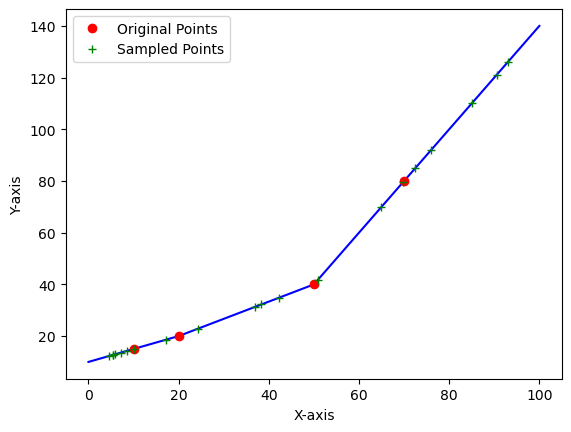

In [3]:
# test segment line and sampling
points = [(10, 15), (20, 20), (50, 40), (70, 80)]
min_x=0.0
max_x=100.0
segments = create_segments(points, left_extension_x=min_x, right_extention_x=max_x)
num_samples = 20
x_values = np.random.uniform(min_x, max_x, num_samples)
x_values.sort()
sampled_points = sample_from_line(segments, x_values)
print(f"Number of Segments: {len(segments)}")
print(f"Number of Sampled Points: {len(sampled_points)}")
plot_segments(segments, points, sampled_points)

In [4]:
fig_dir="/home/jsu/Downloads/cgsul_images/"

18
Found 3 baseline runs for GoToLocalR2
Found 3 baseline runs for PickupLocalR2
Found 3 baseline runs for DropNextToLocalR2
Found 3 baseline runs for OpenBoxLocalR2
Found 3 baseline runs for OpenDoorLocalR2
Found 3 baseline runs for PassDoorLocalR2
GoToLocalR2 3
PickupLocalR2 3
DropNextToLocalR2 3
OpenBoxLocalR2 3
OpenDoorLocalR2 3
PassDoorLocalR2 3


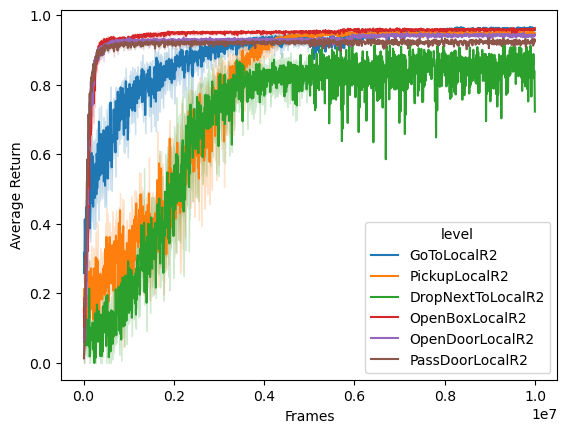

In [5]:
# skill library
data_dir = "/home/jsu/Downloads/cgsul_data/rl_BabyAI/TwoRooms/basic_levels"
basic_level_each_run_dirs = os.listdir(data_dir)
print(len(basic_level_each_run_dirs))
list_of_basic_levels = ["GoToLocalR2", "PickupLocalR2", "DropNextToLocalR2", "OpenBoxLocalR2", "OpenDoorLocalR2", "PassDoorLocalR2"]
basic_level_data = {}
for level in list_of_basic_levels:
    selected_run_dirs = list_all_runs_for_baseline(level, basic_level_each_run_dirs, display_match=False)
    basic_level_data[level] = load_runs_of_all_seeds_for_one_config(level, data_dir, selected_run_dirs)

df_basic_levels = []
for level, runs in basic_level_data.items():
    print(level, len(basic_level_data[level]))
    df_basic_levels.extend(runs)
df_basic_levels = pd.concat(df_basic_levels, axis=0) # concat along rows
g = sns.lineplot(x='frames', y='return_mean', data=df_basic_levels, errorbar='se', err_style='band', hue='level')
g.set(xlabel='Frames', ylabel='Average Return')
fn = "Img_basic_levels_skill_perf.pdf"
fig_fp = os.path.join(fig_dir, fn)
g.figure.savefig(fig_fp, dpi=600, format='pdf')

21
Found 3 baseline runs for DiscoverHiddenBallBlueBoxR2
Found 3 baseline runs for GoToBallNeighborOpenRoomR2
Found 3 baseline runs for MoveToNeighborClosedRoomR2
DiscoverHiddenBallBlueBoxR2 3
GoToBallNeighborOpenRoomR2 3
MoveToNeighborClosedRoomR2 3


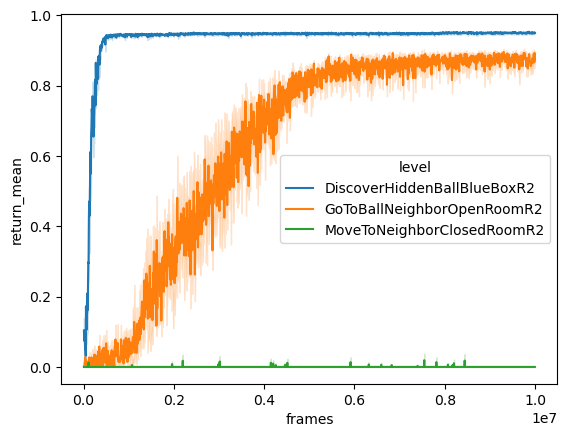

In [6]:
data_dir="/home/jsu/Downloads/cgsul_data/rl_BabyAI/TwoRooms/paper_levels_10M"
paper_level_each_run_dirs = os.listdir(data_dir)
print(len(paper_level_each_run_dirs))
list_of_paper_levels = ["DiscoverHiddenBallBlueBoxR2", "GoToBallNeighborOpenRoomR2", "MoveToNeighborClosedRoomR2"]
paper_level_data = {}
for level in list_of_paper_levels:
    selected_run_dirs = list_all_runs_for_baseline(level, paper_level_each_run_dirs, display_match=False)
    paper_level_data[level] = load_runs_of_all_seeds_for_one_config(level, data_dir, selected_run_dirs)

df_paper_levels = []
for level, runs in paper_level_data.items():
    print(level, len(paper_level_data[level]))
    df_paper_levels.extend(runs)
df_paper_levels = pd.concat(df_paper_levels, axis=0) # concat along rows
gp = sns.lineplot(x='frames', y='return_mean', data=df_paper_levels, errorbar='se', err_style='band', hue='level')
g.set(xlabel='Frames', ylabel='Average Return')
fn = "Img_test_levels_baseline_perf.pdf"
fig_fp = os.path.join(fig_dir, fn)
gp.figure.savefig(fig_fp, dpi=600, format='pdf')

In [7]:
# Plots For Proposed Agent
fig_dir="/home/jsu/Downloads/cgsul_images/"
## Load Experiment Results
exp_result_dir = "/home/jsu/Downloads/cgsul_data/hrl_vlm/TwoRooms/paper_levels"
level = "DiscoverHiddenBallBlueBoxR2"
lr_list = ["0.0001", "3e-05", "1e-05"]
short_lr_list = {"0.0001":"1e-4", "3e-05":"3e-5", "1e-05":"1e-5"}
lang_comp_modes = ["RandomInit", "TuneAll", "FrozenAll"]
history_type = 'full'

df_3lr_3lang_Disc = load_result_per_level(
        exp_result_dir,
        level,
        lr_list,
        short_lr_list,
        lang_comp_modes,
        history_type='full',
        )

total runs: 44
loaded runs: 35


In [8]:
num_samples=1000 # None

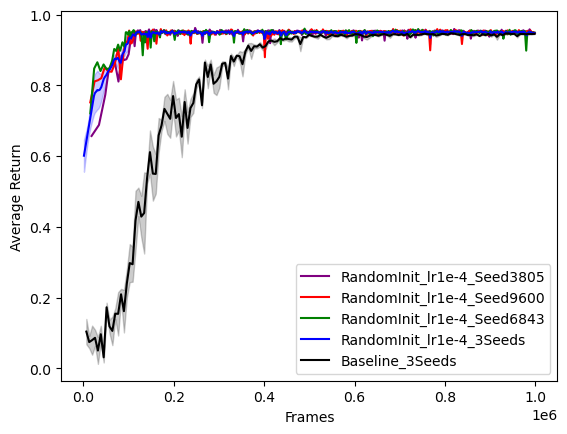

In [9]:
## Show an example of using merged lines of segments to represent the merged performance 
level="DiscoverHiddenBallBlueBoxR2"
lang_comp_mode="RandomInit"
lr="1e-4"
plot_line_segments_example(
        level,
        lang_comp_mode,
        lr,
        df_3lr_3lang_Disc,
        df_paper_levels,
        fig_dir,
        num_samples=num_samples,
)

Ploting training performance for RandomInit mode and level DiscoverHiddenBallBlueBoxR2


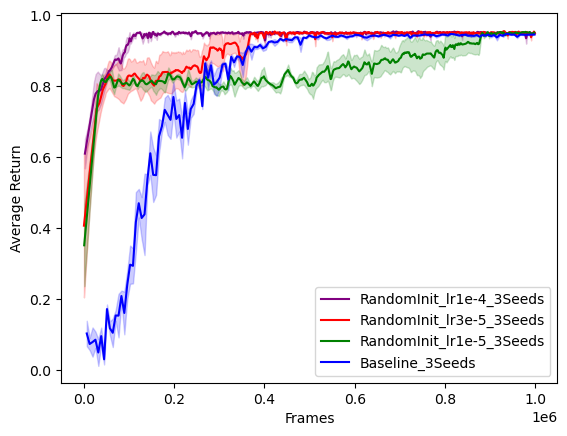

Ploting training performance for TuneAll mode and level DiscoverHiddenBallBlueBoxR2


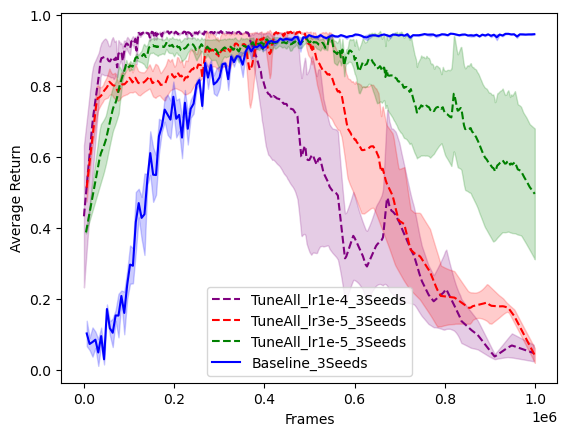

Ploting training performance for FrozenAll mode and level DiscoverHiddenBallBlueBoxR2


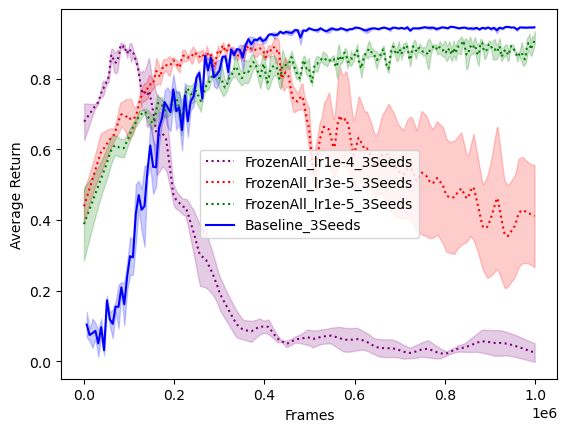

In [10]:
# Initialiation
line_styles = {"RandomInit":"solid", "TuneAll":"dashed", "FrozenAll":"dotted"}
line_colors = {"1e-4":"purple", "3e-5":"red", "1e-5":"green"}

for lang_comp_mode in lang_comp_modes:
        print(f"Ploting training performance for {lang_comp_mode} mode and level {level}")
        gh=None
        plot_perf_per_lang_mode_per_level(
                level,
                lang_comp_mode,
                short_lr_list,
                line_colors,
                line_styles,
                df_3lr_3lang_Disc,
                df_paper_levels,
                fig_dir,
                gh,
                num_samples=num_samples,
        )

Ploting performances of the best lr of each language mode for  level DiscoverHiddenBallBlueBoxR2


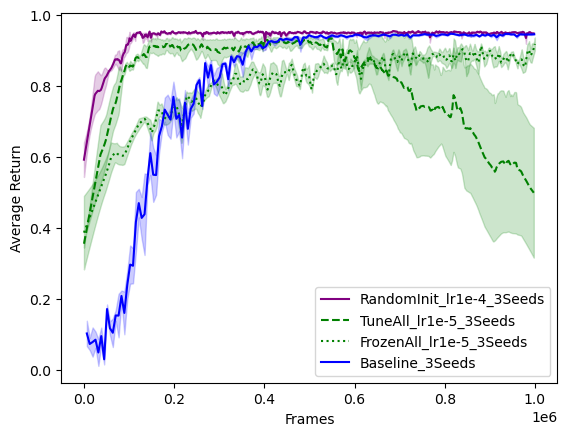

In [11]:
lang_comp_mode_and_lr_pairs = {
    "RandomInit": "1e-4",
    "TuneAll": "1e-5",
    "FrozenAll": "1e-5"
}
print(f"Ploting performances of the best lr of each language mode for  level {level}")
plot_best_perf_every_lang_mode_per_level(
        level,
        lang_comp_mode_and_lr_pairs,
        line_colors,
        line_styles,
        df_3lr_3lang_Disc,
        df_paper_levels,
        fig_dir,
        gh = None,
        num_samples=num_samples,
)

In [12]:
level = "GoToBallNeighborOpenRoomR2"

df_3lr_3lang_GoTo = load_result_per_level(
        exp_result_dir,
        level,
        lr_list,
        short_lr_list,
        lang_comp_modes,
        history_type='full',
        )

total runs: 42
loaded runs: 27


Ploting training performance for RandomInit mode and level GoToBallNeighborOpenRoomR2


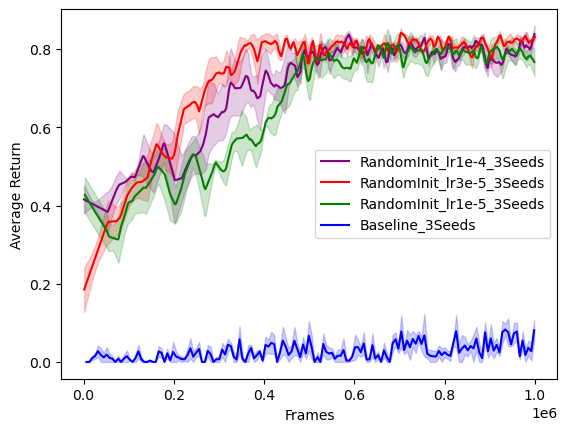

Ploting training performance for TuneAll mode and level GoToBallNeighborOpenRoomR2


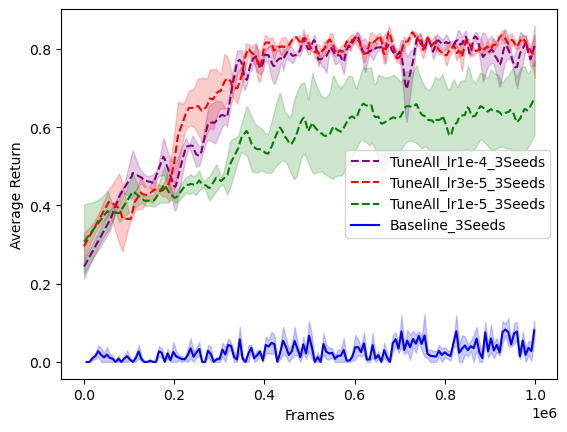

Ploting training performance for FrozenAll mode and level GoToBallNeighborOpenRoomR2


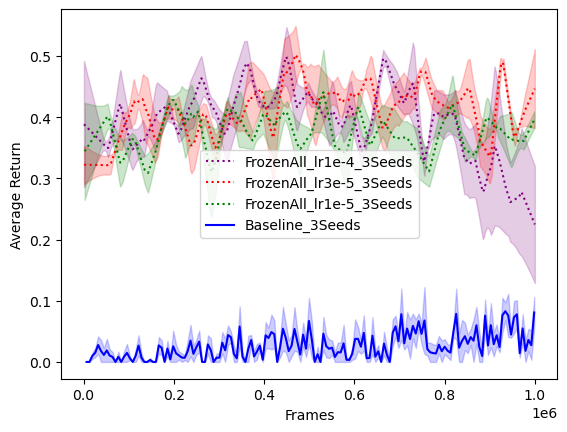

In [13]:
for lang_comp_mode in lang_comp_modes:
        print(f"Ploting training performance for {lang_comp_mode} mode and level {level}")
        gh=None
        plot_perf_per_lang_mode_per_level(
                level,
                lang_comp_mode,
                short_lr_list,
                line_colors,
                line_styles,
                df_3lr_3lang_GoTo,
                df_paper_levels,
                fig_dir,
                gh,
                num_samples=num_samples,
        )

Ploting performances of the best lr of each language mode for  level GoToBallNeighborOpenRoomR2


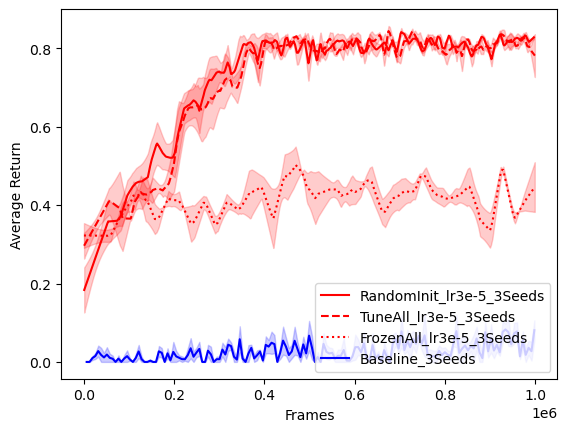

In [14]:
lang_comp_mode_and_lr_pairs = {
    "RandomInit": "3e-5",
    "TuneAll": "3e-5",
    "FrozenAll": "3e-5"
}
print(f"Ploting performances of the best lr of each language mode for  level {level}")
plot_best_perf_every_lang_mode_per_level(
        level,
        lang_comp_mode_and_lr_pairs,
        line_colors,
        line_styles,
        df_3lr_3lang_GoTo,
        df_paper_levels,
        fig_dir,
        gh = None,
        num_samples=num_samples,
)

In [15]:
level = "MoveToNeighborClosedRoomR2"

df_3lr_3lang_Move = load_result_per_level(
        exp_result_dir,
        level,
        lr_list,
        short_lr_list,
        lang_comp_modes,
        history_type='full',
        )

total runs: 37
loaded runs: 27


Ploting training performance for RandomInit mode and level MoveToNeighborClosedRoomR2


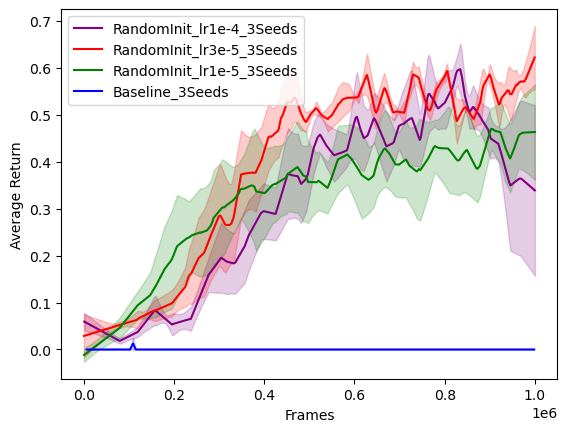

Ploting training performance for TuneAll mode and level MoveToNeighborClosedRoomR2


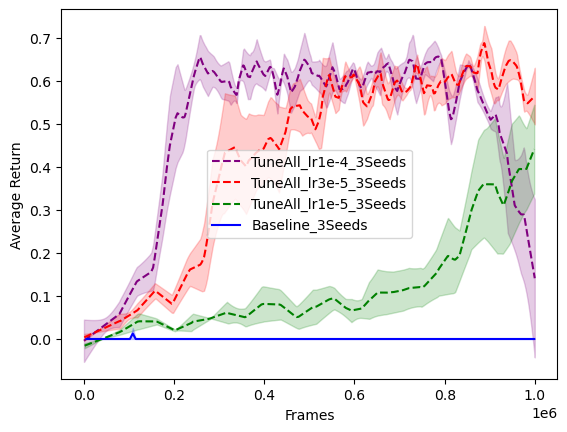

Ploting training performance for FrozenAll mode and level MoveToNeighborClosedRoomR2


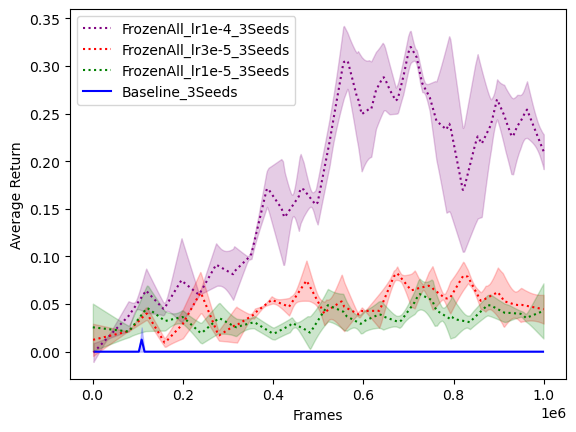

In [16]:
for lang_comp_mode in lang_comp_modes:
        print(f"Ploting training performance for {lang_comp_mode} mode and level {level}")
        gh=None
        plot_perf_per_lang_mode_per_level(
                level,
                lang_comp_mode,
                short_lr_list,
                line_colors,
                line_styles,
                df_3lr_3lang_Move,
                df_paper_levels,
                fig_dir,
                gh,
                num_samples=num_samples,
        )

Ploting performances of the best lr of each language mode for  level MoveToNeighborClosedRoomR2


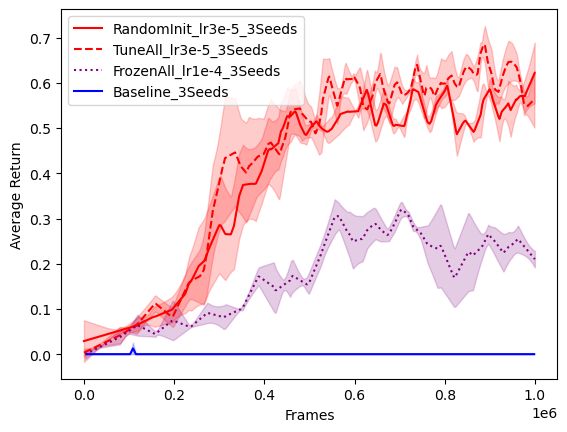

In [17]:
lang_comp_mode_and_lr_pairs = {
    "RandomInit": "3e-5",
    "TuneAll": "3e-5",
    "FrozenAll": "1e-4"
}
print(f"Ploting performances of the best lr of each language mode for  level {level}")
plot_best_perf_every_lang_mode_per_level(
        level,
        lang_comp_mode_and_lr_pairs,
        line_colors,
        line_styles,
        df_3lr_3lang_Move,
        df_paper_levels,
        fig_dir,
        gh = None,
        num_samples=num_samples,
)

In [18]:
# Abstract History vs Full History on Best LR per Language Mode per env

def plot_selected_config(all_results, selected_configs, history_type, line_colors, line_styles, min_x, max_x, num_samples=None, gh=None, abs_marker='x', debug=False):
    num_seeds=3
    num_samples_is_provided = num_samples is not None
    marker = None if history_type=="Full" else abs_marker
    for lang_comp_mode, lr in selected_configs.items():
        df_3seeds = all_results[lang_comp_mode][lr]
        segment_lines = []

        for i in range(3):
            frames_rewards_i = list(zip(df_3seeds[i]['frames'], df_3seeds[i]['return_mean']))
            points = sorted(frames_rewards_i, key=lambda x: x[0])
            if debug:
                print(f"[LR({lr}, Run {i})] left: {points[0]}, right: {points[-1]}, num_points: {len(points)}")

            segments_i = create_segments(points, left_extension_x=min_x, right_extention_x=max_x)
            segment_lines.append(segments_i)
            if debug:
                print(f"[LR({lr}, Extend)] left: {segments_i[0][0]}, right: {segments_i[-1][1]}, num_points: {len(segments_i)+1}")

        max_num_points = find_largest_number_of_points(segment_lines)+1
        if debug:
            print(f"[LR({lr})] max_num_points: {max_num_points}\n")


        line_color = line_colors[lr]
        line_style = line_styles[lang_comp_mode]
        if not num_samples_is_provided:
            num_samples = max_num_points

        x_values = np.random.uniform(min_x, max_x, num_samples)
        x_values.sort()

        df_3seeds = []
        for segments, i in zip(segment_lines, range(num_seeds)):
            sampled_points = sample_from_line(segments, x_values)
            df = pd.DataFrame(sampled_points, columns=['frames', 'return_mean'])
            df_3seeds.append(df)
        df_3seeds = pd.concat(df_3seeds, axis=0)

        if gh is None:
            gh = sns.lineplot(x='frames', y='return_mean', data=df_3seeds, errorbar='se', err_style='band', label=f"{history_type}History_{lang_comp_mode}_lr{lr}", color=line_color, linestyle=line_style, marker=marker)
        else:
            sns.lineplot(x='frames', y='return_mean', data=df_3seeds, errorbar='se', err_style='band', label=f"{history_type}History_{lang_comp_mode}_lr{lr}", color=line_color, linestyle=line_style, marker=marker, ax=gh)

    return gh

def plot_full_vs_abs_selected_lang_mode_per_level(
        level,
        selected_configs,
        abs_line_colors,
        line_colors,
        line_styles,
        df_paper_levels,
        df_full,
        df_abs,
        fig_dir,
        gh = None,
        debug=False,
        num_samples=None,
        abs_marker='x'
):
    min_x=0.0
    max_x=1e6
    gh = None

    plt.figure()
    history_type="Full"
    gh = None
    gh = plot_selected_config(df_full, selected_configs, history_type, line_colors, line_styles, min_x, max_x, num_samples, gh, abs_marker, debug)
    history_type="Abs"
    gh = plot_selected_config(df_abs, selected_configs, history_type, abs_line_colors, line_styles, min_x, max_x, num_samples, gh, abs_marker,debug)

    baseline_data = df_paper_levels[df_paper_levels['level']==level]
    baseline_data = baseline_data[baseline_data['frames']<=max_x]
    sns.lineplot(x='frames', y='return_mean', data=baseline_data, errorbar='se', err_style='band', color="blue",  label='Baseline', ax=gh)

    gh.set(xlabel='Frames', ylabel='Average Return')
    fn = f"Img_full_vs_abs_{level}.pdf"
    fig_fp = os.path.join(fig_dir, fn)
    gh.figure.savefig(fig_fp, dpi=600, format='pdf')
    plt.show()
    plt.close(gh.figure)


def load_abs_result_per_level(
        exp_result_dir,
        level,
        selected_lr_list,
        lang_comp_mode_and_lr_pairs,
        history_type='absR0',
        ):

    level_exp_result_dir= os.path.join(exp_result_dir, level)
    each_run_dirs = os.listdir(level_exp_result_dir)
    print(f"total runs: {len(each_run_dirs)}")

    dfs = {}
    loaded_runs = 0
    for lang_comp_mode, short_lr_name in lang_comp_mode_and_lr_pairs.items():
        dfs[lang_comp_mode] = {}
        dfs[lang_comp_mode][short_lr_name] = []

    for (lang_comp_mode, short_lr_name), lr in zip(lang_comp_mode_and_lr_pairs.items(), selected_lr_list):
        filename_regex = f"^BabyAI-{level}-v0_ppo_HRL-Flamingo_{history_type}_all_Lang{lang_comp_mode}_noPrior_lr{lr}"
        for run_dir in each_run_dirs:
            if re.match(filename_regex, run_dir):
                df = load_log(os.path.join(level_exp_result_dir, run_dir), level)
                df['lr'] = short_lr_name
                df['lang_mode'] = lang_comp_mode
                dfs[lang_comp_mode][short_lr_name].append(df)
                loaded_runs += 1

    print(f"loaded runs: {loaded_runs}")
    return dfs



In [19]:
#abs_line_colors = {"1e-4":"deepskyblue", "3e-5":"gold", "1e-5":"coral"}
abs_line_colors = {"1e-4":"mediumslateblue", "3e-5":"mediumseagreen", "1e-5":"darkkhaki"}

total runs: 44
loaded runs: 6


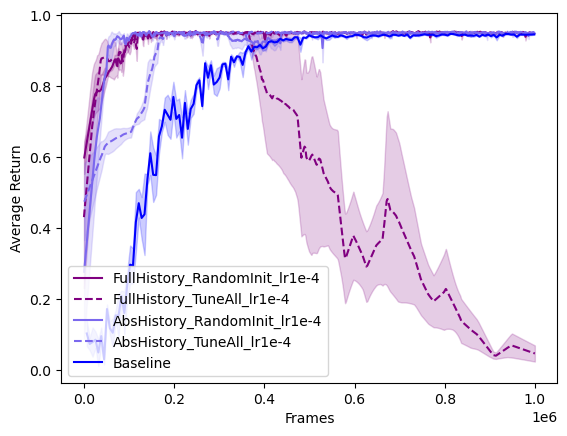

In [20]:
level="DiscoverHiddenBallBlueBoxR2"
selected_configs = {
    "RandomInit": "1e-4",
    "TuneAll": "1e-4", # currently the results with '1e-5' is not ready, use the resulsts with '1e-4' instead
}
# lr_list = ["0.0001", "3e-05", "1e-05"]
selected_lr_list = ["0.0001", "0.0001"]

df_abs_Disc = load_abs_result_per_level(
        exp_result_dir,
        level,
        selected_lr_list,
        selected_configs,
        history_type='absR0',
        )
plot_full_vs_abs_selected_lang_mode_per_level(
        level,
        selected_configs,
        abs_line_colors,
        line_colors,
        line_styles,
        df_paper_levels,
        df_3lr_3lang_Disc,
        df_abs_Disc,
        fig_dir,
        gh = None,
        debug=False,
        num_samples=num_samples,
        abs_marker=None
)

total runs: 42
loaded runs: 6


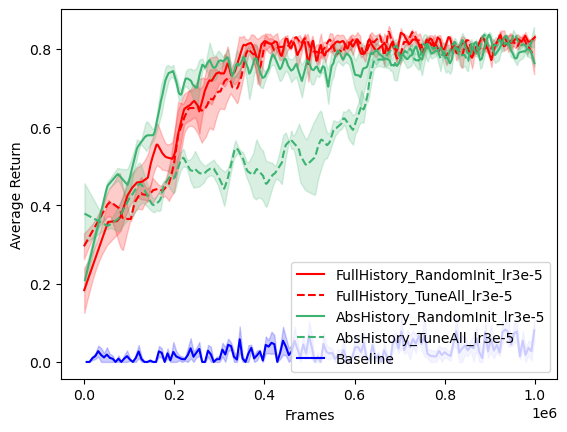

In [21]:
level="GoToBallNeighborOpenRoomR2"
selected_configs = {
    "RandomInit": "3e-5",
    "TuneAll": "3e-5",
}
# lr_list = ["0.0001", "3e-05", "1e-05"]
selected_lr_list = ["3e-05", "3e-05"]

df_abs_GoTo = load_abs_result_per_level(
        exp_result_dir,
        level,
        selected_lr_list,
        selected_configs,
        history_type='absR0',
        )
plot_full_vs_abs_selected_lang_mode_per_level(
        level,
        selected_configs,
        abs_line_colors,
        line_colors,
        line_styles,
        df_paper_levels,
        df_3lr_3lang_GoTo,
        df_abs_GoTo,
        fig_dir,
        gh = None,
        debug=False,
        num_samples=num_samples,
        abs_marker=None
)

total runs: 37
loaded runs: 6


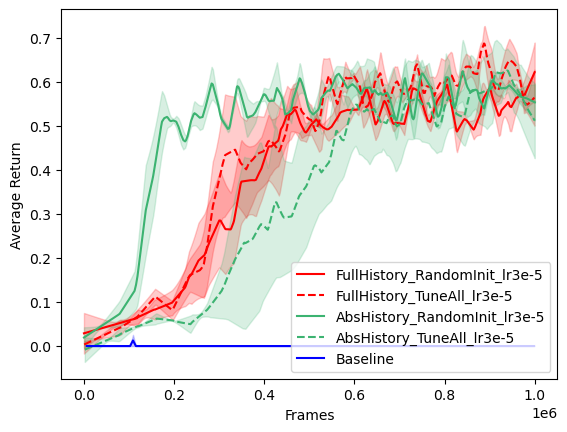

In [22]:
level="MoveToNeighborClosedRoomR2"
selected_configs = {
    "RandomInit": "3e-5",
    "TuneAll": "3e-5",
}
# lr_list = ["0.0001", "3e-05", "1e-05"]
selected_lr_list = ["3e-05", "3e-05"]

df_abs_Move = load_abs_result_per_level(
        exp_result_dir,
        level,
        selected_lr_list,
        selected_configs,
        history_type='absR0',
        )
plot_full_vs_abs_selected_lang_mode_per_level(
        level,
        selected_configs,
        abs_line_colors,
        line_colors,
        line_styles,
        df_paper_levels,
        df_3lr_3lang_Move,
        df_abs_Move,
        fig_dir,
        gh = None,
        debug=False,
        num_samples=num_samples,
        abs_marker=None
)